## Import Library

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

**Insight:**

Pada tahap ini dilakukan import seluruh library yang dibutuhkan dalam proyek. Library seperti `pandas`, `matplotlib`, dan `seaborn` digunakan untuk eksplorasi dan visualisasi data. Sementara `sklearn` digunakan untuk preprocessing, pembagian data, pelatihan model, evaluasi, dan tuning.


## Load Data

In [2]:
# Load the dataset
file_path = '../data/obesity_data.csv'
df = pd.read_csv(file_path)

# Menampilkan dataset
df.head()


,Age,Gender,Height,Weight,BMI,PhysicalActivityLevel,ObesityCategory
0,56,Male,173.575262,71.982051,23.891783,4,Normal weight
1,69,Male,164.127306,89.959256,33.395209,2,Obese
2,46,Female,168.072202,72.930629,25.817737,4,Overweight
3,32,Male,168.459633,84.886912,29.912247,3,Overweight
4,60,Male,183.568568,69.038945,20.487903,3,Normal weight


**Insight:**

Dataset "Obesity Prediction" dimuat dari file CSV. Dataset ini berisi informasi usia, tinggi, berat, BMI, aktivitas fisik, gender, dan kategori obesitas. Proses awal ini penting untuk memastikan data berhasil dimuat dan siap dianalisis.


## Exploratory Data Analysis (EDA)

In [3]:
# Cek dimensi data
print(f'Dimensi dataset: {df.shape}')

Dimensi dataset: (1000, 7)


In [4]:
# Cek informasi data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    1000 non-null   int64  
 1   Gender                 1000 non-null   object 
 2   Height                 1000 non-null   float64
 3   Weight                 1000 non-null   float64
 4   BMI                    1000 non-null   float64
 5   PhysicalActivityLevel  1000 non-null   int64  
 6   ObesityCategory        1000 non-null   object 
dtypes: float64(3), int64(2), object(2)
memory usage: 54.8+ KB


In [5]:
# Cek tipe data
print(df.dtypes)

Age                        int64
Gender                    object
Height                   float64
Weight                   float64
BMI                      float64
PhysicalActivityLevel      int64
ObesityCategory           object
dtype: object


In [6]:
# Statistik deskriptif untuk fitur numerik
df.describe()

,Age,Height,Weight,BMI,PhysicalActivityLevel
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,49.857000,170.052417,71.205769,24.888317,2.534000
std,18.114267,10.309971,15.509849,6.193912,1.116284
min,18.000000,136.115719,26.065730,8.470572,1.000000
25%,35.000000,163.514205,61.129629,20.918068,2.000000
50%,50.000000,169.801665,71.929072,24.698647,3.000000
75%,66.000000,177.353596,81.133746,28.732132,4.000000
max,79.000000,201.419670,118.907366,50.791898,4.000000


In [7]:
# Mengecek duplikasi data
print(f'Jumlah duplikat data: {df.duplicated().sum()}')

# Mengecek nilai null
print(f'\nJumlah missing values:\n{df.isnull().sum()}')

Jumlah duplikat data: 0

Jumlah missing values:
Age                      0
Gender                   0
Height                   0
Weight                   0
BMI                      0
PhysicalActivityLevel    0
ObesityCategory          0
dtype: int64


Tidak ada missing value dan data yang duplikat, maka tidak perlu preprocessing menghapus data duplikat dan null.

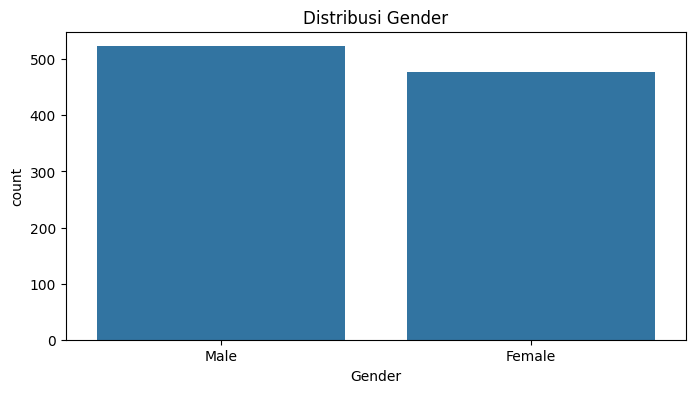

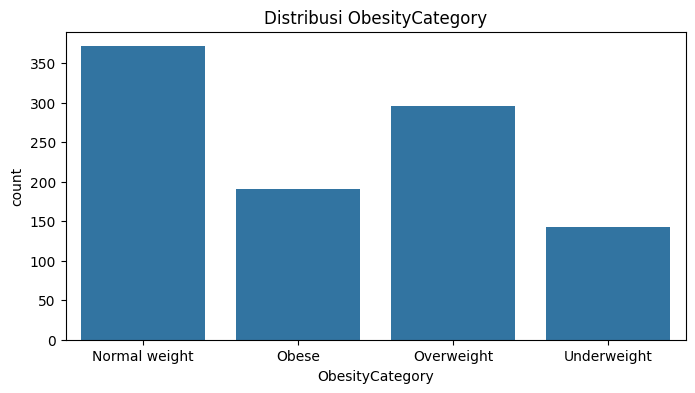

In [8]:
# Visualisasi distribusi data kategorikal
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(x=col, data=df)
    plt.title(f'Distribusi {col}')
    plt.show()

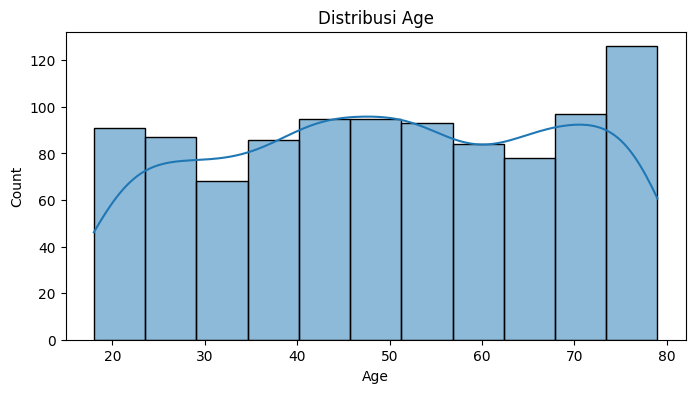

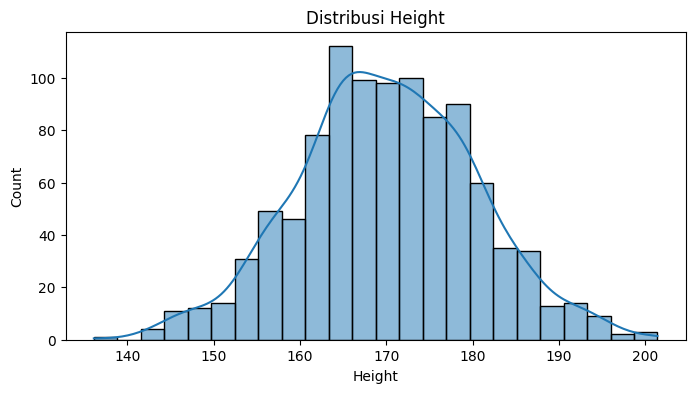

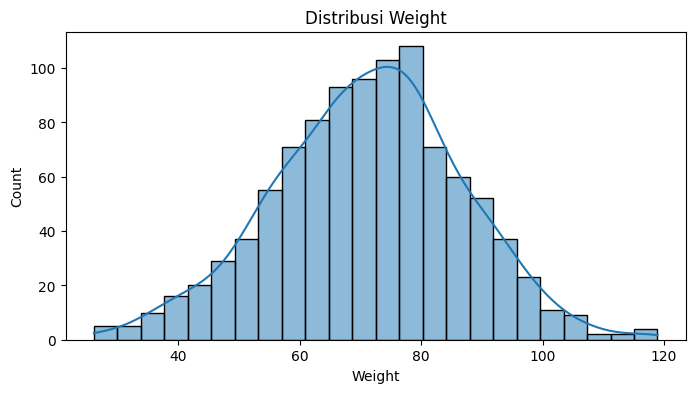

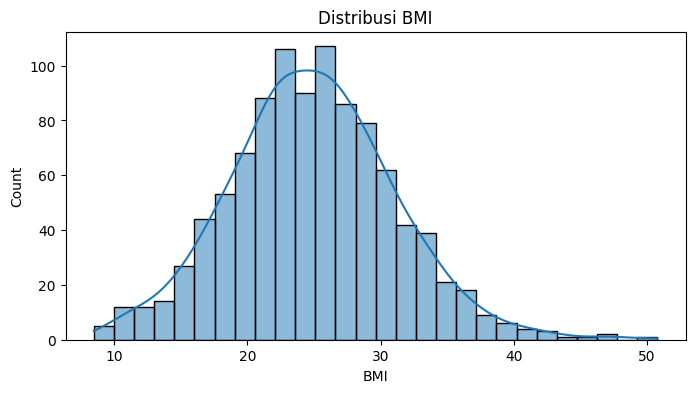

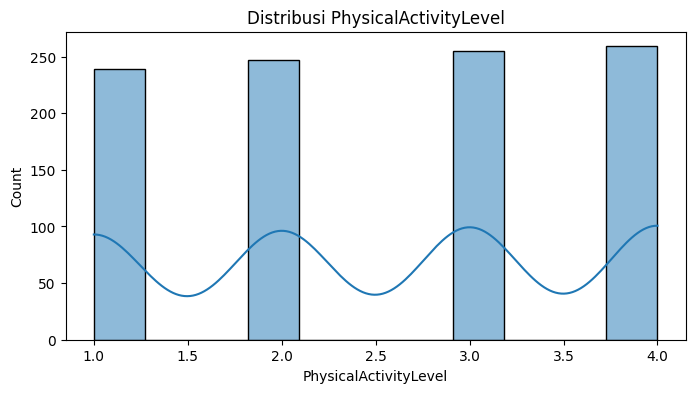

In [9]:
# Visualisasi distribusi data numerik
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True)
    plt.title(f'Distribusi {col}')
    plt.show()

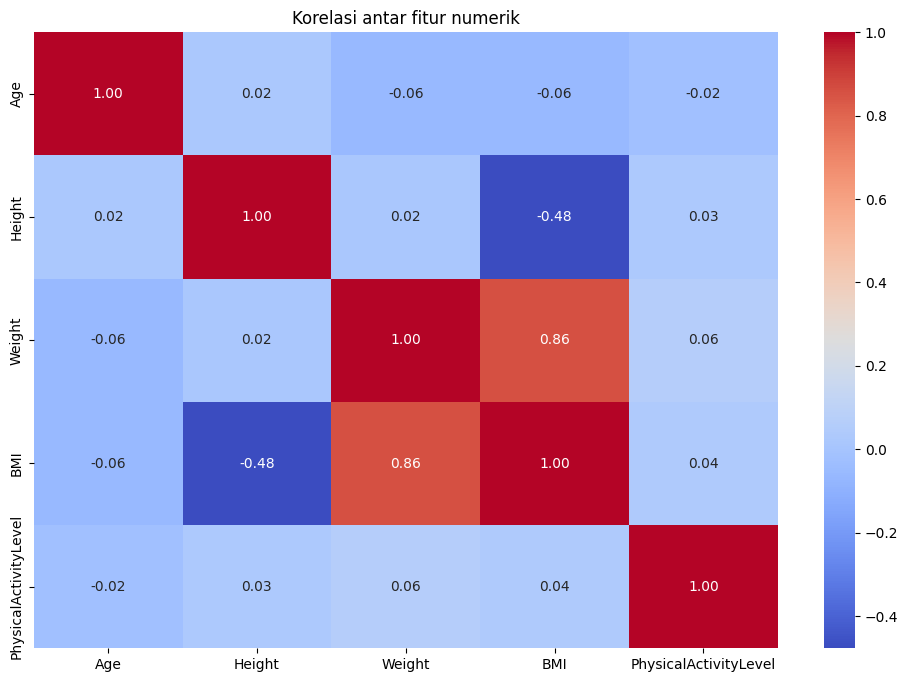

In [10]:
# Korelasi heatmap antar fitur numerik
plt.figure(figsize=(12, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Korelasi antar fitur numerik')
plt.show()

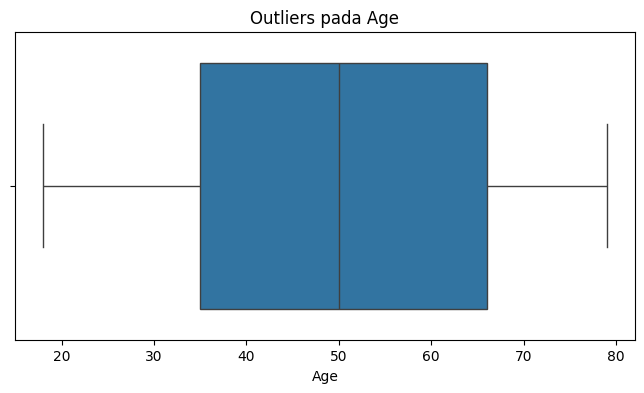

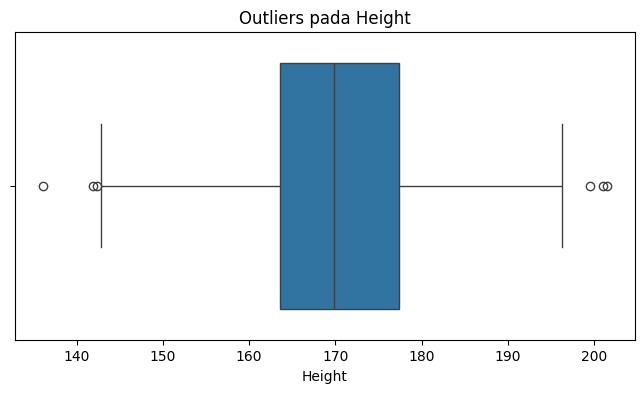

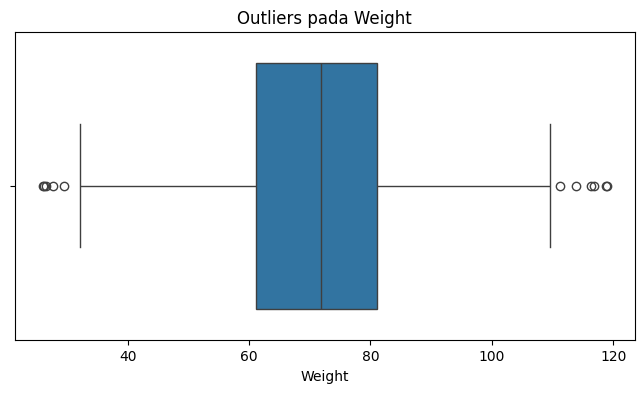

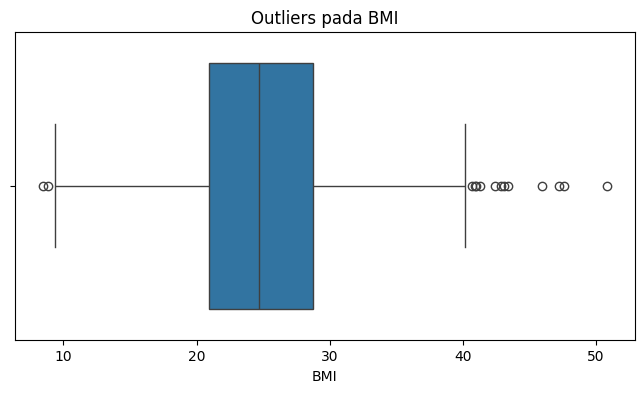

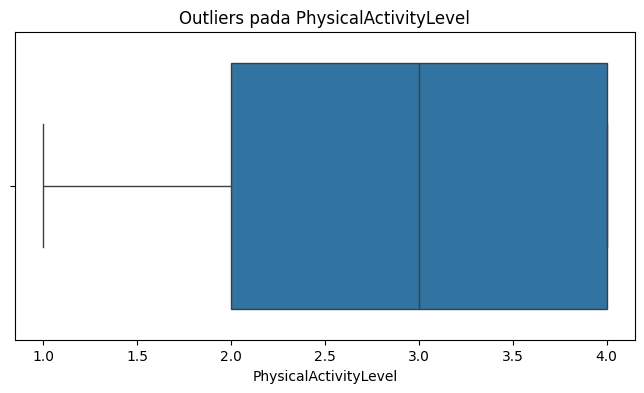

In [11]:
# Boxplot untuk mendeteksi outliers pada fitur numerik
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Outliers pada {col}')
    plt.show()

Dari visualisasi boxplot, terlihat ada outlier pada fitur BMI, tinggi badan, dan berat badan. Namun, dalam data kesehatan, nilai-nilai tersebut bisa saja wajar karena mencerminkan kondisi nyata seseorang.

Outlier tidak dihapus karena:
- Masih berada dalam batas yang mungkin terjadi secara fisiologis.
- Bisa jadi informasi penting untuk mendeteksi obesitas atau underweight.
- Model seperti Random Forest cukup kuat terhadap outlier.

**Insight:**

Tahapan ini digunakan untuk memahami struktur data, distribusi nilai, dan hubungan antar fitur:

- Dataset terdiri dari 1.000 baris dan 7 kolom.
- Tidak ditemukan missing values dan data duplikat.
- Distribusi kelas target tidak seimbang.
- Visualisasi distribusi fitur menunjukkan sebaran data normal pada BMI, berat badan, dan tinggi badan.
- Korelasi kuat terlihat antara berat badan dan BMI.

Temuan ini membantu dalam merancang strategi preprocessing dan memilih algoritma model yang tepat.

## Preprocessing Data

In [12]:
# Mengubah tipe data kolom PhysicalActivityLevel menjadi kategorikal
df['PhysicalActivityLevel'] = df['PhysicalActivityLevel'].astype('category')

df.dtypes

Age                         int64
Gender                     object
Height                    float64
Weight                    float64
BMI                       float64
PhysicalActivityLevel    category
ObesityCategory            object
dtype: object

In [13]:
# One Hot Encoding untuk fitur Gender
df = pd.get_dummies(df, columns=['Gender'], drop_first=True)

# Label Encoding untuk fitur PhysicalActivityLevel
label_encoder = LabelEncoder()
df['PhysicalActivityLevel'] = label_encoder.fit_transform(df['PhysicalActivityLevel'])

# Melihat hasil encoding
df.head()

,Age,Height,Weight,BMI,PhysicalActivityLevel,ObesityCategory,Gender_Male
0,56,173.575262,71.982051,23.891783,3,Normal weight,True
1,69,164.127306,89.959256,33.395209,1,Obese,True
2,46,168.072202,72.930629,25.817737,3,Overweight,False
3,32,168.459633,84.886912,29.912247,2,Overweight,True
4,60,183.568568,69.038945,20.487903,2,Normal weight,True


In [14]:
# Fit & transform
df['ObesityCategory'] = label_encoder.fit_transform(df['ObesityCategory'])

# Cek hasil mapping
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_mapping)

{'Normal weight': 0, 'Obese': 1, 'Overweight': 2, 'Underweight': 3}


In [15]:
# Standarisasi fitur Age, Height, Weight, BMI
scaler = StandardScaler()

df[['Age', 'Height', 'Weight', 'BMI']] = scaler.fit_transform(df[['Age', 'Height', 'Weight', 'BMI']])

In [16]:
# Cek hasil preprocessing
df.head()

,Age,Height,Weight,BMI,PhysicalActivityLevel,ObesityCategory,Gender_Male
0,0.339295,0.341864,0.050076,-0.160970,3,0,True
1,1.057320,-0.574985,1.209739,1.374115,1,1,True
2,-0.213033,-0.192164,0.111266,0.150129,3,2,False
3,-0.986291,-0.154567,0.882535,0.811514,2,2,True
4,0.560226,1.311635,-0.139776,-0.710797,2,0,True


**Insight:**

Beberapa langkah preprocessing dilakukan agar data siap digunakan oleh model:

1. **Pengubahan tipe data** – Fitur `PhysicalActivityLevel` diubah menjadi kategori.
2. **Encoding** – 
   - `Gender` diencoding dengan OneHotEncoder.
   - `PhysicalActivityLevel` dan `ObesityCategory` menggunakan LabelEncoder.
3. **Standarisasi fitur numerik** – Fitur `Age`, `Height`, `Weight`, dan `BMI` distandarisasi agar memiliki skala seragam.
4. **Outlier** – Meskipun ditemukan outlier, tidak dilakukan penghapusan karena masih tergolong wajar dalam data kesehatan.

Langkah ini memastikan model dapat belajar dengan efektif dari fitur yang bersih dan terstruktur.


## Data Splitting

In [17]:
# Membagi data menjadi fitur dan target
X = df.drop('ObesityCategory', axis=1)
y = df['ObesityCategory']

# Split data ke training dan test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Cek dimensi data training dan test
print(f'Dimensi data training: {X_train.shape}, {y_train.shape}')
print(f'Dimensi data test: {X_test.shape}, {y_test.shape}')

Dimensi data training: (800, 6), (800,)
Dimensi data test: (200, 6), (200,)


**Insight:**

Data dibagi menjadi data latih (80%) dan data uji (20%) menggunakan `train_test_split`. Ini bertujuan untuk mengevaluasi kinerja model pada data yang belum pernah dilihat sebelumnya. Stratifikasi dilakukan secara default untuk menjaga proporsi distribusi kelas target tetap konsisten.


## Training and Evaluation

In [18]:
# Model 1: Logistic Regression
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)

In [19]:
# Evaluasi Logistic Regression
print("\nLogistic Regression Evaluation:")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print("Precision:", precision_score(y_test, y_pred_log, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_log, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_log, average='weighted'))


Logistic Regression Evaluation:
Accuracy: 0.965
Precision: 0.9658024943774279
Recall: 0.965
F1 Score: 0.9651112056946864


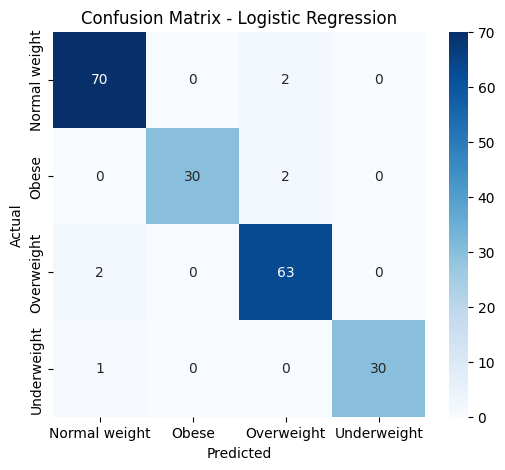

Classification Report - Logistic Regression:
               precision    recall  f1-score   support

Normal weight       0.96      0.97      0.97        72
        Obese       1.00      0.94      0.97        32
   Overweight       0.94      0.97      0.95        65
  Underweight       1.00      0.97      0.98        31

     accuracy                           0.96       200
    macro avg       0.97      0.96      0.97       200
 weighted avg       0.97      0.96      0.97       200



In [20]:
# Confusion Matrix untuk Logistic Regression
cm_log = confusion_matrix(y_test, y_pred_log)
plt.figure(figsize=(6,5))
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print("Classification Report - Logistic Regression:")
print(classification_report(y_test, y_pred_log, target_names=label_encoder.classes_))

In [21]:
# Model 2: Random Forest dengan GridSearchCV
rf = RandomForestClassifier(random_state=42)
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5]
}
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)
best_rf = grid_search_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)

In [22]:
# Evaluasi Random Forest
print("\nRandom Forest Tuned Evaluation:")
print("Best Parameters:", grid_search_rf.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_rf, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_rf, average='weighted'))


Random Forest Tuned Evaluation:
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Accuracy: 0.995
Precision: 0.9950757575757575
Recall: 0.995
F1 Score: 0.994979401429783


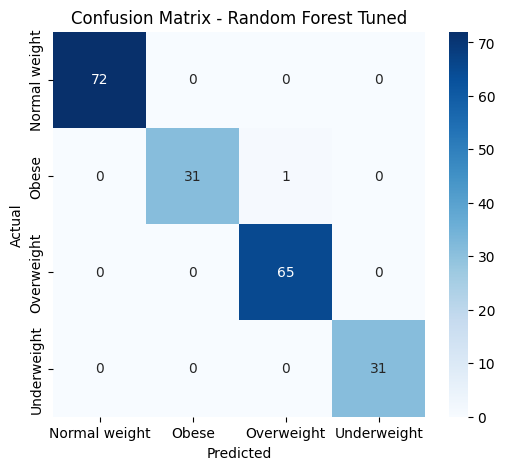

Classification Report - Random Forest:
               precision    recall  f1-score   support

Normal weight       1.00      1.00      1.00        72
        Obese       1.00      0.97      0.98        32
   Overweight       0.98      1.00      0.99        65
  Underweight       1.00      1.00      1.00        31

     accuracy                           0.99       200
    macro avg       1.00      0.99      0.99       200
 weighted avg       1.00      0.99      0.99       200



In [23]:
# Confusion Matrix untuk Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(6,5))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - Random Forest Tuned')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print("Classification Report - Random Forest:")
print(classification_report(y_test, y_pred_rf, target_names=label_encoder.classes_))

In [24]:
# Model 3: Support Vector Machine (SVM) dengan GridSearchCV
svm = SVC(probability=True, random_state=42)
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}
grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_svm.fit(X_train, y_train)
best_svm = grid_search_svm.best_estimator_
y_pred_svm = best_svm.predict(X_test)

In [25]:
# Evaluasi SVM
print("\nSVM Tuned Evaluation:")
print("Best Parameters:", grid_search_svm.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Precision:", precision_score(y_test, y_pred_svm, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_svm, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_svm, average='weighted'))


SVM Tuned Evaluation:
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Accuracy: 0.98
Precision: 0.9802373426163038
Recall: 0.98
F1 Score: 0.9800048043559494


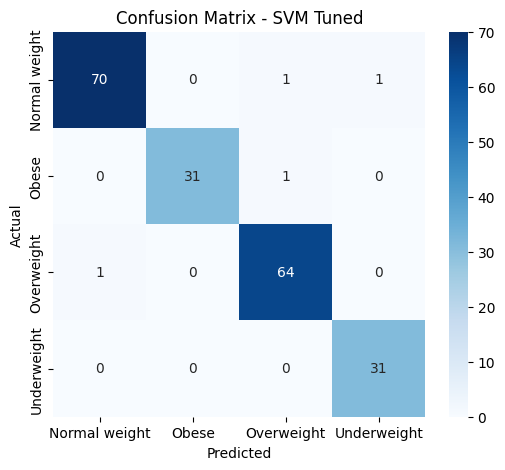

Classification Report - SVM:
               precision    recall  f1-score   support

Normal weight       0.99      0.97      0.98        72
        Obese       1.00      0.97      0.98        32
   Overweight       0.97      0.98      0.98        65
  Underweight       0.97      1.00      0.98        31

     accuracy                           0.98       200
    macro avg       0.98      0.98      0.98       200
 weighted avg       0.98      0.98      0.98       200



In [26]:
# Confusion Matrix untuk SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6,5))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix - SVM Tuned')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()
print("Classification Report - SVM:")
print(classification_report(y_test, y_pred_svm, target_names=label_encoder.classes_))

## Evaluation

In [33]:
# Perbandingan Performa Model
models_comparison = {
    'Model': ['Logistic Regression', 'Random Forest', 'SVM'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_log),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_svm)
    ],
    'Precision': [
        precision_score(y_test, y_pred_log, average='weighted'),
        precision_score(y_test, y_pred_rf, average='weighted'),
        precision_score(y_test, y_pred_svm, average='weighted')
    ],
    'Recall': [
        recall_score(y_test, y_pred_log, average='weighted'),
        recall_score(y_test, y_pred_rf, average='weighted'),
        recall_score(y_test, y_pred_svm, average='weighted')
    ],
    'F1 Score': [
        f1_score(y_test, y_pred_log, average='weighted'),
        f1_score(y_test, y_pred_rf, average='weighted'),
        f1_score(y_test, y_pred_svm, average='weighted')
    ]
}

comparison_df = pd.DataFrame(models_comparison)
print("\nPerbandingan Performa Model:")
comparison_df


Perbandingan Performa Model:


,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.965,0.965802,0.965,0.965111
1,Random Forest,0.995,0.995076,0.995,0.994979
2,SVM,0.980,0.980237,0.980,0.980005


/var/folders/pv/hl8lt53s3212m50jmr0nb5q00000gp/T/ipykernel_78490/3765391797.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Model', y='Accuracy', data=comparison_df, palette=['#1f77b4', '#2ca02c', '#ff7f0e'])  # Warna berbeda untuk setiap model


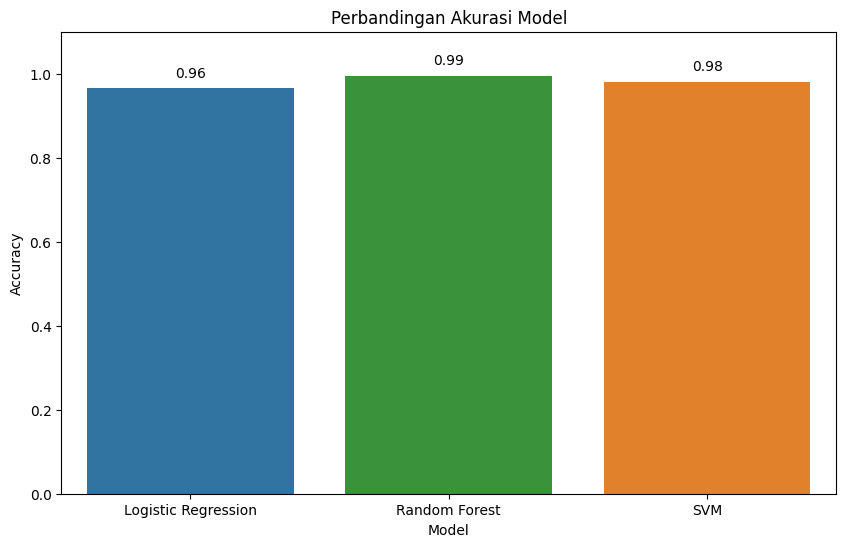

In [31]:
# Visualisasi Perbandingan dengan angka akurasi dan warna berbeda
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x='Model', y='Accuracy', data=comparison_df, palette=['#1f77b4', '#2ca02c', '#ff7f0e'])  # Warna berbeda untuk setiap model
plt.title('Perbandingan Akurasi Model')
plt.ylim(0, 1.1)  # Memberi ruang untuk teks di atas bar

# Menambahkan angka akurasi di atas bar
for index, row in comparison_df.iterrows():
    plt.text(index, row['Accuracy'] + 0.02, f'{row["Accuracy"]:.2f}', 
             ha='center', va='bottom', fontsize=10, color='black')

plt.show()

## Insight dari Hasil Training dan Evaluasi

Berdasarkan evaluasi ketiga model (Logistic Regression, Random Forest, dan SVM) pada dataset obesitas, diperoleh beberapa temuan penting:

1. **Performa Model**:
   - **Random Forest** menunjukkan performa terbaik dengan akurasi sebesar 0.995, diikuti oleh **SVM** dengan akurasi 0.980, dan **Logistic Regression** dengan akurasi 0.965. Hal ini menunjukkan bahwa Random Forest mampu mengklasifikasikan kategori obesitas dengan tingkat keberhasilan tertinggi.
   - Ketiga model memiliki presisi, recall, dan F1-score yang tinggi (di atas 0.96 untuk semua model), tetapi Random Forest unggul secara konsisten di semua metrik, terutama dengan skor macro avg dan weighted avg mendekati 1.00.

2. **Confusion Matrix**:
   - **Logistic Regression**: Menunjukkan 70 prediksi benar untuk "Normal weight", 30 untuk "Obese", 63 untuk "Overweight", dan 30 untuk "Underweight". Namun, terdapat beberapa kesalahan prediksi, seperti 2 kasus "Normal weight" salah diprediksi sebagai "Overweight" dan 2 kasus "Obese" salah diprediksi sebagai "Overweight".
   - **Random Forest**: Hampir sempurna dengan 72, 31, 65, dan 31 prediksi benar untuk masing-masing kelas, dengan hanya 1 kesalahan pada kelas "Obese" (salah diprediksi sebagai "Overweight"). Ini mencerminkan kemampuan Random Forest untuk menangani kompleksitas data dengan baik.
   - **SVM**: Menunjukkan 70, 31, 64, dan 31 prediksi benar, dengan sedikit kesalahan (misalnya, 1 "Normal weight" salah diprediksi sebagai "Overweight" atau "Underweight"). Performa SVM sedikit di bawah Random Forest, tetapi tetap sangat baik.

3. **Hyperparameter Tuning**:
   - Random Forest menggunakan parameter terbaik `{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}`, yang memungkinkan model untuk tumbuh penuh dan menangkap pola kompleks dalam data.
   - SVM menggunakan parameter terbaik `{'C': 10, 'gamma': 'scale', 'kernel': 'linear'}`, menunjukkan bahwa kernel linear dengan regularisasi tinggi (C=10) memberikan hasil optimal untuk dataset ini.

4. **Kesimpulan**:
   - Random Forest adalah model terbaik untuk tugas ini karena akurasinya yang tinggi (0.995) dan kemampuannya untuk meminimalkan kesalahan prediksi. Hal ini kemungkinan disebabkan oleh kemampuan Random Forest untuk menangani interaksi non-linear antara fitur seperti `Age`, `BMI`, dan `PhysicalActivityLevel`.
   - Logistic Regression, meskipun sederhana, masih memberikan performa yang baik (0.965), tetapi kurang kompetitif dibandingkan model berbasis pohon keputusan.
   - SVM menawarkan kompromi yang baik antara kompleksitas dan akurasi (0.980), tetapi tidak sebaik Random Forest dalam kasus ini.
   - Berdasarkan hasil ini, model Random Forest dipilih untuk inferensi karena performanya yang unggul, yang akan memberikan prediksi yang lebih andal untuk data baru.

5. **Rekomendasi**:
   - Pertimbangkan untuk mengeksplorasi fitur tambahan atau preprocessing lanjutan (misalnya, feature engineering atau handling outlier) untuk meningkatkan performa Logistic Regression atau SVM jika diperlukan untuk aplikasi tertentu.
   - Uji coba dengan dataset yang lebih besar atau berbeda dapat memvalidasi apakah Random Forest tetap unggul di berbagai skenario.

## Inference

In [32]:
# Inference dengan model terbaik menggunakan Random Forest
best_model = best_rf
new_data = pd.DataFrame({
    'Age': [30],
    'Height': [170],
    'Weight': [70],
    'BMI': [24.2],
    'PhysicalActivityLevel': [3],  # Use integer directly
    'Gender_Male': [1]
})

# Standarisasi fitur numerik
new_data_scaled = new_data.copy()
new_data_scaled[['Age', 'Height', 'Weight', 'BMI']] = scaler.transform(new_data[['Age', 'Height', 'Weight', 'BMI']])

# Prediksi numerik
prediksi_label_num = best_model.predict(new_data_scaled)

# Ubah ke label asli
prediksi_label_str = label_encoder.inverse_transform(prediksi_label_num)
print(f"\nPrediksi kategori obesitas: {prediksi_label_str[0]}")

# Probabilitas prediksi
prediksi_prob = best_model.predict_proba(new_data_scaled)[0]
prob_dict = dict(zip(label_encoder.classes_, prediksi_prob))
print("\nProbabilitas prediksi per kategori:")
for label, prob in prob_dict.items():
    print(f"{label}: {prob:.4f}")


Prediksi kategori obesitas: Normal weight

Probabilitas prediksi per kategori:
Normal weight: 0.9700
Obese: 0.0000
Overweight: 0.0300
Underweight: 0.0000
